<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:12:56] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


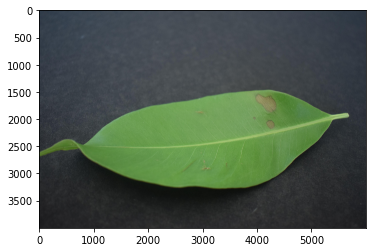

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

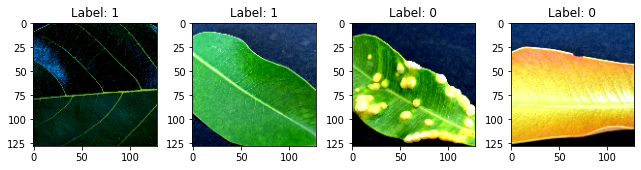

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:03] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:05] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2527800015367396 samples/sec                   batch loss = 0.569438099861145 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2611020388067453 samples/sec                   batch loss = 0.6738321781158447 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2630395656711515 samples/sec                   batch loss = 0.3334866762161255 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2663921204356086 samples/sec                   batch loss = 0.8545722961425781 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.272566468877932 samples/sec                   batch loss = 1.8396110534667969 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2680422547325552 samples/sec                   batch loss = 0.5093086361885071 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2640158963943726 samples/sec                   batch loss = 1.9384218454360962 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2602319572141096 samples/sec                   batch loss = 0.39747098088264465 | accuracy = 0.6625


Epoch[1] Batch[45] Speed: 1.2649177244832503 samples/sec                   batch loss = 0.7649964094161987 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.2659551341376778 samples/sec                   batch loss = 0.3027896285057068 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2649042776767287 samples/sec                   batch loss = 0.5765213370323181 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2568267768602719 samples/sec                   batch loss = 0.518805980682373 | accuracy = 0.6458333333333334


Epoch[1] Batch[65] Speed: 1.26213699452918 samples/sec                   batch loss = 0.8450089693069458 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.2565466420558358 samples/sec                   batch loss = 0.7715599536895752 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2609616646133182 samples/sec                   batch loss = 0.4542679190635681 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2579732787031397 samples/sec                   batch loss = 0.5821439623832703 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2635492390371361 samples/sec                   batch loss = 0.4684414565563202 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2606683161769834 samples/sec                   batch loss = 0.4997606873512268 | accuracy = 0.6277777777777778


Epoch[1] Batch[95] Speed: 1.2573639569499473 samples/sec                   batch loss = 0.7207629084587097 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2575755451966173 samples/sec                   batch loss = 0.6665112376213074 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2580765721367935 samples/sec                   batch loss = 0.5346039533615112 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.2624346367211825 samples/sec                   batch loss = 0.42250749468803406 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2686075802731605 samples/sec                   batch loss = 0.5918349027633667 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.259364776988263 samples/sec                   batch loss = 0.3339308202266693 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2681497965181319 samples/sec                   batch loss = 0.4351285398006439 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.268456131768947 samples/sec                   batch loss = 0.7282541394233704 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.262915206162965 samples/sec                   batch loss = 0.32175034284591675 | accuracy = 0.6333333333333333


Epoch[1] Batch[140] Speed: 1.2659721378037865 samples/sec                   batch loss = 0.6223900318145752 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.262334615565483 samples/sec                   batch loss = 0.25531408190727234 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.2585484473026287 samples/sec                   batch loss = 0.3741898834705353 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.261475542712469 samples/sec                   batch loss = 1.0964909791946411 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.256917263739007 samples/sec                   batch loss = 0.08701018989086151 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2613222835796702 samples/sec                   batch loss = 0.46288245916366577 | accuracy = 0.6378787878787879


Epoch[1] Batch[170] Speed: 1.2650748158041756 samples/sec                   batch loss = 0.3018283545970917 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2599703625021066 samples/sec                   batch loss = 0.4831262528896332 | accuracy = 0.6485714285714286


Epoch[1] Batch[180] Speed: 1.260512411946712 samples/sec                   batch loss = 1.1043182611465454 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.252745015946775 samples/sec                   batch loss = 0.3787100911140442 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.256802862630002 samples/sec                   batch loss = 0.5591960549354553 | accuracy = 0.65


Epoch[1] Batch[195] Speed: 1.2663243501217587 samples/sec                   batch loss = 0.8493095636367798 | accuracy = 0.6525641025641026


Epoch[1] Batch[200] Speed: 1.2639600926143777 samples/sec                   batch loss = 0.3839910626411438 | accuracy = 0.6575


Epoch[1] Batch[205] Speed: 1.2696299156282491 samples/sec                   batch loss = 0.30819171667099 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.2672561820903665 samples/sec                   batch loss = 0.5190265774726868 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.2692508959046853 samples/sec                   batch loss = 0.8097445368766785 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2707745906525458 samples/sec                   batch loss = 0.29085612297058105 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.2774921302792195 samples/sec                   batch loss = 0.5148691534996033 | accuracy = 0.6544444444444445


Epoch[1] Batch[230] Speed: 1.2716462835996198 samples/sec                   batch loss = 0.49559885263442993 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2728390180943834 samples/sec                   batch loss = 0.6465043425559998 | accuracy = 0.6542553191489362


Epoch[1] Batch[240] Speed: 1.2694301000345254 samples/sec                   batch loss = 0.44833359122276306 | accuracy = 0.6572916666666667


Epoch[1] Batch[245] Speed: 1.272109875151799 samples/sec                   batch loss = 0.43326336145401 | accuracy = 0.6591836734693878


Epoch[1] Batch[250] Speed: 1.2722742574539736 samples/sec                   batch loss = 0.3154701888561249 | accuracy = 0.66


Epoch[1] Batch[255] Speed: 1.275114615952765 samples/sec                   batch loss = 0.40770840644836426 | accuracy = 0.6627450980392157


Epoch[1] Batch[260] Speed: 1.27267844805169 samples/sec                   batch loss = 0.8419320583343506 | accuracy = 0.6634615384615384


Epoch[1] Batch[265] Speed: 1.2759111502110698 samples/sec                   batch loss = 0.6332521438598633 | accuracy = 0.6641509433962264


Epoch[1] Batch[270] Speed: 1.277356058512311 samples/sec                   batch loss = 1.3179707527160645 | accuracy = 0.6648148148148149


Epoch[1] Batch[275] Speed: 1.2733686166075884 samples/sec                   batch loss = 0.5003941059112549 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2726136714890648 samples/sec                   batch loss = 0.4166022539138794 | accuracy = 0.6616071428571428


Epoch[1] Batch[285] Speed: 1.272734831232239 samples/sec                   batch loss = 0.4980992376804352 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.2765971564139715 samples/sec                   batch loss = 0.4070555865764618 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.2731494589317263 samples/sec                   batch loss = 0.37806352972984314 | accuracy = 0.6677966101694915


Epoch[1] Batch[300] Speed: 1.2711093527123558 samples/sec                   batch loss = 0.3312041163444519 | accuracy = 0.67


Epoch[1] Batch[305] Speed: 1.269956576628104 samples/sec                   batch loss = 0.6931344270706177 | accuracy = 0.6704918032786885


Epoch[1] Batch[310] Speed: 1.2784179733636507 samples/sec                   batch loss = 0.5857086181640625 | accuracy = 0.6717741935483871


Epoch[1] Batch[315] Speed: 1.2719405209240884 samples/sec                   batch loss = 0.5579583048820496 | accuracy = 0.6714285714285714


Epoch[1] Batch[320] Speed: 1.272935495467279 samples/sec                   batch loss = 0.9856738448143005 | accuracy = 0.67109375


Epoch[1] Batch[325] Speed: 1.2741407141460304 samples/sec                   batch loss = 0.4494341015815735 | accuracy = 0.6707692307692308


Epoch[1] Batch[330] Speed: 1.2745040706955124 samples/sec                   batch loss = 0.6197619438171387 | accuracy = 0.668939393939394


Epoch[1] Batch[335] Speed: 1.273007355986305 samples/sec                   batch loss = 0.37505239248275757 | accuracy = 0.6686567164179105


Epoch[1] Batch[340] Speed: 1.2746915406990769 samples/sec                   batch loss = 0.5333658456802368 | accuracy = 0.6698529411764705


Epoch[1] Batch[345] Speed: 1.2709035836186524 samples/sec                   batch loss = 1.1657806634902954 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2686150625172592 samples/sec                   batch loss = 0.5269396305084229 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2769010754996 samples/sec                   batch loss = 0.20038358867168427 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2690444801284806 samples/sec                   batch loss = 0.5802762508392334 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.2699212979871284 samples/sec                   batch loss = 1.5849511623382568 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.268539380809228 samples/sec                   batch loss = 0.3534865975379944 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.27769916280063 samples/sec                   batch loss = 0.9009226560592651 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.2733481277727714 samples/sec                   batch loss = 0.777872622013092 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.2720832538465294 samples/sec                   batch loss = 0.912043035030365 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.267870628228345 samples/sec                   batch loss = 0.454558402299881 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2659678390810114 samples/sec                   batch loss = 0.7269018292427063 | accuracy = 0.6708860759493671


Epoch[1] Batch[400] Speed: 1.2702800394987876 samples/sec                   batch loss = 0.5876567959785461 | accuracy = 0.6725


Epoch[1] Batch[405] Speed: 1.26378319101863 samples/sec                   batch loss = 0.819430410861969 | accuracy = 0.671604938271605


Epoch[1] Batch[410] Speed: 1.2676485697561548 samples/sec                   batch loss = 0.46886080503463745 | accuracy = 0.6725609756097561


Epoch[1] Batch[415] Speed: 1.2698773706481885 samples/sec                   batch loss = 0.5332625508308411 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2696764202018607 samples/sec                   batch loss = 0.25046247243881226 | accuracy = 0.6732142857142858


Epoch[1] Batch[425] Speed: 1.2649850581831348 samples/sec                   batch loss = 0.7182363867759705 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.2679773742602773 samples/sec                   batch loss = 0.3397001624107361 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.2690957417798232 samples/sec                   batch loss = 0.9639994502067566 | accuracy = 0.6764367816091954


Epoch[1] Batch[440] Speed: 1.2716590066437397 samples/sec                   batch loss = 0.553865373134613 | accuracy = 0.6772727272727272


Epoch[1] Batch[445] Speed: 1.2688024351738938 samples/sec                   batch loss = 0.58121657371521 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.270260226988802 samples/sec                   batch loss = 0.5959994792938232 | accuracy = 0.6772222222222222


Epoch[1] Batch[455] Speed: 1.2766400927247137 samples/sec                   batch loss = 0.32735681533813477 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.2633772092155693 samples/sec                   batch loss = 0.6178301572799683 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.2668029121065898 samples/sec                   batch loss = 0.5623883605003357 | accuracy = 0.6779569892473118


Epoch[1] Batch[470] Speed: 1.266644817570237 samples/sec                   batch loss = 0.6224098801612854 | accuracy = 0.676063829787234


Epoch[1] Batch[475] Speed: 1.2648049136853567 samples/sec                   batch loss = 0.6002588868141174 | accuracy = 0.6747368421052632


Epoch[1] Batch[480] Speed: 1.266489248228244 samples/sec                   batch loss = 0.337518572807312 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.2665531159583638 samples/sec                   batch loss = 0.37945568561553955 | accuracy = 0.6752577319587629


Epoch[1] Batch[490] Speed: 1.2653934103244575 samples/sec                   batch loss = 0.8175418972969055 | accuracy = 0.6744897959183673


Epoch[1] Batch[495] Speed: 1.2642339211816023 samples/sec                   batch loss = 0.3280448913574219 | accuracy = 0.6737373737373737


Epoch[1] Batch[500] Speed: 1.262625604305741 samples/sec                   batch loss = 0.5752772688865662 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.2632530685653645 samples/sec                   batch loss = 0.17204298079013824 | accuracy = 0.6757425742574258


Epoch[1] Batch[510] Speed: 1.2657060541342835 samples/sec                   batch loss = 0.5729567408561707 | accuracy = 0.675


Epoch[1] Batch[515] Speed: 1.2711049227274074 samples/sec                   batch loss = 0.22160634398460388 | accuracy = 0.6766990291262136


Epoch[1] Batch[520] Speed: 1.2765302320421625 samples/sec                   batch loss = 1.419296145439148 | accuracy = 0.6759615384615385


Epoch[1] Batch[525] Speed: 1.2689973499422578 samples/sec                   batch loss = 0.454284131526947 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2674232379138166 samples/sec                   batch loss = 0.2532445192337036 | accuracy = 0.6787735849056604


Epoch[1] Batch[535] Speed: 1.268164942013778 samples/sec                   batch loss = 0.28658977150917053 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.2691534400900264 samples/sec                   batch loss = 0.9264954328536987 | accuracy = 0.6787037037037037


Epoch[1] Batch[545] Speed: 1.267645696342734 samples/sec                   batch loss = 0.5167964696884155 | accuracy = 0.6793577981651376


Epoch[1] Batch[550] Speed: 1.2729614763583286 samples/sec                   batch loss = 0.2189616858959198 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.2750110252037334 samples/sec                   batch loss = 0.7298455238342285 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.270984554520611 samples/sec                   batch loss = 0.3435122072696686 | accuracy = 0.6816964285714285


Epoch[1] Batch[565] Speed: 1.2738066748220018 samples/sec                   batch loss = 0.43884509801864624 | accuracy = 0.6831858407079646


Epoch[1] Batch[570] Speed: 1.2683555377744635 samples/sec                   batch loss = 0.3348536193370819 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.2726020877019917 samples/sec                   batch loss = 0.7285186648368835 | accuracy = 0.6847826086956522


Epoch[1] Batch[580] Speed: 1.274269423586023 samples/sec                   batch loss = 0.3095671534538269 | accuracy = 0.6844827586206896


Epoch[1] Batch[585] Speed: 1.269964170924364 samples/sec                   batch loss = 0.5526465773582458 | accuracy = 0.685042735042735


Epoch[1] Batch[590] Speed: 1.265275361837925 samples/sec                   batch loss = 0.41893482208251953 | accuracy = 0.6855932203389831


Epoch[1] Batch[595] Speed: 1.273548502087281 samples/sec                   batch loss = 0.36470991373062134 | accuracy = 0.6852941176470588


Epoch[1] Batch[600] Speed: 1.2745571299564322 samples/sec                   batch loss = 0.9846315979957581 | accuracy = 0.6858333333333333


Epoch[1] Batch[605] Speed: 1.2719028177777232 samples/sec                   batch loss = 0.34199216961860657 | accuracy = 0.6863636363636364


Epoch[1] Batch[610] Speed: 1.2744466593549804 samples/sec                   batch loss = 1.0591779947280884 | accuracy = 0.6868852459016394


Epoch[1] Batch[615] Speed: 1.2726290203317638 samples/sec                   batch loss = 0.40399467945098877 | accuracy = 0.6873983739837398


Epoch[1] Batch[620] Speed: 1.266850644709715 samples/sec                   batch loss = 0.4505298137664795 | accuracy = 0.6879032258064516


Epoch[1] Batch[625] Speed: 1.274037088073353 samples/sec                   batch loss = 0.47537776827812195 | accuracy = 0.688


Epoch[1] Batch[630] Speed: 1.2656480004912556 samples/sec                   batch loss = 0.35835951566696167 | accuracy = 0.6884920634920635


Epoch[1] Batch[635] Speed: 1.2770935287504102 samples/sec                   batch loss = 1.0193932056427002 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2687024578269812 samples/sec                   batch loss = 0.3520190119743347 | accuracy = 0.691796875


Epoch[1] Batch[645] Speed: 1.2699756106053748 samples/sec                   batch loss = 0.3224896788597107 | accuracy = 0.6910852713178295


Epoch[1] Batch[650] Speed: 1.269699577675371 samples/sec                   batch loss = 2.408482313156128 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.266830173774061 samples/sec                   batch loss = 0.3851472735404968 | accuracy = 0.6927480916030534


Epoch[1] Batch[660] Speed: 1.2721372692522686 samples/sec                   batch loss = 0.5662267208099365 | accuracy = 0.6909090909090909


Epoch[1] Batch[665] Speed: 1.2756958695648373 samples/sec                   batch loss = 0.7930480241775513 | accuracy = 0.6913533834586466


Epoch[1] Batch[670] Speed: 1.273715673910817 samples/sec                   batch loss = 0.32033053040504456 | accuracy = 0.691044776119403


Epoch[1] Batch[675] Speed: 1.2730146004404086 samples/sec                   batch loss = 0.3576087951660156 | accuracy = 0.69


Epoch[1] Batch[680] Speed: 1.274188807788697 samples/sec                   batch loss = 0.4979225695133209 | accuracy = 0.6900735294117647


Epoch[1] Batch[685] Speed: 1.276187561024515 samples/sec                   batch loss = 0.3714474141597748 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.2747262131986143 samples/sec                   batch loss = 0.8782298564910889 | accuracy = 0.6894927536231884


Epoch[1] Batch[695] Speed: 1.2723253944142776 samples/sec                   batch loss = 0.43721237778663635 | accuracy = 0.689568345323741


Epoch[1] Batch[700] Speed: 1.2718038938060074 samples/sec                   batch loss = 0.3555614948272705 | accuracy = 0.6892857142857143


Epoch[1] Batch[705] Speed: 1.28088400854044 samples/sec                   batch loss = 0.4437461495399475 | accuracy = 0.6897163120567376


Epoch[1] Batch[710] Speed: 1.2794964872069539 samples/sec                   batch loss = 0.45703640580177307 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2652342361324889 samples/sec                   batch loss = 0.597076416015625 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.2693210925659613 samples/sec                   batch loss = 0.3220009505748749 | accuracy = 0.6909722222222222


Epoch[1] Batch[725] Speed: 1.2667229513169989 samples/sec                   batch loss = 0.3705888092517853 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2643534905074478 samples/sec                   batch loss = 0.1572921872138977 | accuracy = 0.6921232876712329


Epoch[1] Batch[735] Speed: 1.2683833457672664 samples/sec                   batch loss = 0.7429263591766357 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2626805300585897 samples/sec                   batch loss = 0.7308030128479004 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.269376314274069 samples/sec                   batch loss = 0.6271446347236633 | accuracy = 0.6912751677852349


Epoch[1] Batch[750] Speed: 1.2744493700607842 samples/sec                   batch loss = 0.44058677554130554 | accuracy = 0.6916666666666667


Epoch[1] Batch[755] Speed: 1.2786940096506354 samples/sec                   batch loss = 0.6390628814697266 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.270439523858997 samples/sec                   batch loss = 0.8791744112968445 | accuracy = 0.6921052631578948


Epoch[1] Batch[765] Speed: 1.2683145951216517 samples/sec                   batch loss = 1.1823455095291138 | accuracy = 0.6918300653594771


Epoch[1] Batch[770] Speed: 1.2718495936114962 samples/sec                   batch loss = 0.4219560921192169 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.2660191390773203 samples/sec                   batch loss = 0.1572325974702835 | accuracy = 0.6929032258064516


Epoch[1] Batch[780] Speed: 1.2671174012925082 samples/sec                   batch loss = 0.9625364542007446 | accuracy = 0.6926282051282051


Epoch[1] Batch[785] Speed: 1.2682677108807154 samples/sec                   batch loss = 0.47803106904029846 | accuracy = 0.693312101910828


[Epoch 1] training: accuracy=0.6935279187817259
[Epoch 1] time cost: 648.9620797634125
[Epoch 1] validation: validation accuracy=0.72


Epoch[2] Batch[5] Speed: 1.2609550305497879 samples/sec                   batch loss = 0.3225977420806885 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2618125402560927 samples/sec                   batch loss = 0.5143842101097107 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2611352175574944 samples/sec                   batch loss = 0.7239468693733215 | accuracy = 0.6166666666666667


Epoch[2] Batch[20] Speed: 1.2609049930052503 samples/sec                   batch loss = 0.5388367176055908 | accuracy = 0.625


Epoch[2] Batch[25] Speed: 1.267436738330527 samples/sec                   batch loss = 0.8167526125907898 | accuracy = 0.59


Epoch[2] Batch[30] Speed: 1.269399076619963 samples/sec                   batch loss = 0.8287217020988464 | accuracy = 0.6166666666666667


Epoch[2] Batch[35] Speed: 1.2700579054768715 samples/sec                   batch loss = 0.3922431170940399 | accuracy = 0.6214285714285714


Epoch[2] Batch[40] Speed: 1.2672179904116558 samples/sec                   batch loss = 0.2634998559951782 | accuracy = 0.65


Epoch[2] Batch[45] Speed: 1.2677232830776723 samples/sec                   batch loss = 0.4196242392063141 | accuracy = 0.65


Epoch[2] Batch[50] Speed: 1.267765241342685 samples/sec                   batch loss = 0.6605050563812256 | accuracy = 0.655


Epoch[2] Batch[55] Speed: 1.2611962710205755 samples/sec                   batch loss = 0.8625946044921875 | accuracy = 0.6590909090909091


Epoch[2] Batch[60] Speed: 1.2591519247769793 samples/sec                   batch loss = 0.4217796325683594 | accuracy = 0.6708333333333333


Epoch[2] Batch[65] Speed: 1.2619400997985675 samples/sec                   batch loss = 0.7939956188201904 | accuracy = 0.6730769230769231


Epoch[2] Batch[70] Speed: 1.2637404488152915 samples/sec                   batch loss = 0.5087960958480835 | accuracy = 0.6821428571428572


Epoch[2] Batch[75] Speed: 1.2570678529921644 samples/sec                   batch loss = 0.2684524953365326 | accuracy = 0.6833333333333333


Epoch[2] Batch[80] Speed: 1.2551358199270988 samples/sec                   batch loss = 0.2949208915233612 | accuracy = 0.696875


Epoch[2] Batch[85] Speed: 1.263968472389798 samples/sec                   batch loss = 0.4367271661758423 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.258743718366753 samples/sec                   batch loss = 0.27337491512298584 | accuracy = 0.7111111111111111


Epoch[2] Batch[95] Speed: 1.259120362236542 samples/sec                   batch loss = 1.385389804840088 | accuracy = 0.7026315789473684


Epoch[2] Batch[100] Speed: 1.2556248492420135 samples/sec                   batch loss = 0.5209092497825623 | accuracy = 0.695


Epoch[2] Batch[105] Speed: 1.2569528594429082 samples/sec                   batch loss = 0.29342955350875854 | accuracy = 0.7047619047619048


Epoch[2] Batch[110] Speed: 1.268392455547299 samples/sec                   batch loss = 0.8133052587509155 | accuracy = 0.7022727272727273


Epoch[2] Batch[115] Speed: 1.2615264792705754 samples/sec                   batch loss = 0.6785688996315002 | accuracy = 0.7


Epoch[2] Batch[120] Speed: 1.2637366411868742 samples/sec                   batch loss = 0.8481899499893188 | accuracy = 0.69375


Epoch[2] Batch[125] Speed: 1.257609858418955 samples/sec                   batch loss = 0.7441104054450989 | accuracy = 0.692


Epoch[2] Batch[130] Speed: 1.263612905752577 samples/sec                   batch loss = 0.5594457387924194 | accuracy = 0.6846153846153846


Epoch[2] Batch[135] Speed: 1.2631267650382576 samples/sec                   batch loss = 0.25681301951408386 | accuracy = 0.6888888888888889


Epoch[2] Batch[140] Speed: 1.2624916359218756 samples/sec                   batch loss = 0.7330729365348816 | accuracy = 0.6928571428571428


Epoch[2] Batch[145] Speed: 1.261633487895295 samples/sec                   batch loss = 0.49710142612457275 | accuracy = 0.696551724137931


Epoch[2] Batch[150] Speed: 1.2616336776430217 samples/sec                   batch loss = 1.401563286781311 | accuracy = 0.6966666666666667


Epoch[2] Batch[155] Speed: 1.2636647765039861 samples/sec                   batch loss = 0.5941658020019531 | accuracy = 0.7


Epoch[2] Batch[160] Speed: 1.2621859904199384 samples/sec                   batch loss = 0.7637302875518799 | accuracy = 0.7015625


Epoch[2] Batch[165] Speed: 1.2641359007336446 samples/sec                   batch loss = 0.4641059935092926 | accuracy = 0.706060606060606


Epoch[2] Batch[170] Speed: 1.258491709191567 samples/sec                   batch loss = 0.5389737486839294 | accuracy = 0.7073529411764706


Epoch[2] Batch[175] Speed: 1.2599838938626124 samples/sec                   batch loss = 0.24153275787830353 | accuracy = 0.7057142857142857


Epoch[2] Batch[180] Speed: 1.2594290626723978 samples/sec                   batch loss = 0.3351104259490967 | accuracy = 0.7069444444444445


Epoch[2] Batch[185] Speed: 1.2626112559776088 samples/sec                   batch loss = 1.2303920984268188 | accuracy = 0.7067567567567568


Epoch[2] Batch[190] Speed: 1.263880585501321 samples/sec                   batch loss = 0.592560350894928 | accuracy = 0.7092105263157895


Epoch[2] Batch[195] Speed: 1.2622587316453076 samples/sec                   batch loss = 0.3636692762374878 | accuracy = 0.7102564102564103


Epoch[2] Batch[200] Speed: 1.2629027525460597 samples/sec                   batch loss = 0.16824711859226227 | accuracy = 0.71


Epoch[2] Batch[205] Speed: 1.262586551011204 samples/sec                   batch loss = 0.5372459888458252 | accuracy = 0.7097560975609756


Epoch[2] Batch[210] Speed: 1.2607311244634523 samples/sec                   batch loss = 0.22130970656871796 | accuracy = 0.7107142857142857


Epoch[2] Batch[215] Speed: 1.2577976716385908 samples/sec                   batch loss = 0.40608644485473633 | accuracy = 0.7151162790697675


Epoch[2] Batch[220] Speed: 1.2639947551334576 samples/sec                   batch loss = 0.497753381729126 | accuracy = 0.7136363636363636


Epoch[2] Batch[225] Speed: 1.2662065101361633 samples/sec                   batch loss = 0.4439745545387268 | accuracy = 0.7166666666666667


Epoch[2] Batch[230] Speed: 1.2632840776601362 samples/sec                   batch loss = 0.2314607948064804 | accuracy = 0.716304347826087


Epoch[2] Batch[235] Speed: 1.263688762217842 samples/sec                   batch loss = 0.432622492313385 | accuracy = 0.7170212765957447


Epoch[2] Batch[240] Speed: 1.2583552188217575 samples/sec                   batch loss = 0.48191118240356445 | accuracy = 0.7166666666666667


Epoch[2] Batch[245] Speed: 1.2601141125781083 samples/sec                   batch loss = 0.4935929775238037 | accuracy = 0.7142857142857143


Epoch[2] Batch[250] Speed: 1.2548784951884104 samples/sec                   batch loss = 0.5847130417823792 | accuracy = 0.713


Epoch[2] Batch[255] Speed: 1.2533078287440436 samples/sec                   batch loss = 0.40607598423957825 | accuracy = 0.711764705882353


Epoch[2] Batch[260] Speed: 1.2569332721394442 samples/sec                   batch loss = 0.5426821112632751 | accuracy = 0.7125


Epoch[2] Batch[265] Speed: 1.2591360488103505 samples/sec                   batch loss = 0.6881443858146667 | accuracy = 0.7113207547169811


Epoch[2] Batch[270] Speed: 1.2550143262188844 samples/sec                   batch loss = 0.6171711683273315 | accuracy = 0.712037037037037


Epoch[2] Batch[275] Speed: 1.2592826332171319 samples/sec                   batch loss = 0.1877211332321167 | accuracy = 0.7109090909090909


Epoch[2] Batch[280] Speed: 1.2598858690415926 samples/sec                   batch loss = 0.4301077425479889 | accuracy = 0.7125


Epoch[2] Batch[285] Speed: 1.2624423313127644 samples/sec                   batch loss = 0.4791914224624634 | accuracy = 0.7149122807017544


Epoch[2] Batch[290] Speed: 1.2567513653895563 samples/sec                   batch loss = 0.15909944474697113 | accuracy = 0.7129310344827586


Epoch[2] Batch[295] Speed: 1.2554706596161065 samples/sec                   batch loss = 0.40044859051704407 | accuracy = 0.714406779661017


Epoch[2] Batch[300] Speed: 1.2518928694362763 samples/sec                   batch loss = 0.8616735935211182 | accuracy = 0.7158333333333333


Epoch[2] Batch[305] Speed: 1.2519934849715701 samples/sec                   batch loss = 0.3173811137676239 | accuracy = 0.7155737704918033


Epoch[2] Batch[310] Speed: 1.2585213520922638 samples/sec                   batch loss = 0.3168871998786926 | accuracy = 0.7169354838709677


Epoch[2] Batch[315] Speed: 1.2549125675216473 samples/sec                   batch loss = 0.21438847482204437 | accuracy = 0.7182539682539683


Epoch[2] Batch[320] Speed: 1.2528189182854024 samples/sec                   batch loss = 0.35657215118408203 | accuracy = 0.71875


Epoch[2] Batch[325] Speed: 1.2572787762654123 samples/sec                   batch loss = 0.48472803831100464 | accuracy = 0.7169230769230769


Epoch[2] Batch[330] Speed: 1.259934311834421 samples/sec                   batch loss = 0.4135633111000061 | accuracy = 0.718939393939394


Epoch[2] Batch[335] Speed: 1.259196341810402 samples/sec                   batch loss = 0.5200648307800293 | accuracy = 0.7201492537313433


Epoch[2] Batch[340] Speed: 1.2572676583992972 samples/sec                   batch loss = 0.08681520819664001 | accuracy = 0.7198529411764706


Epoch[2] Batch[345] Speed: 1.2556168616463794 samples/sec                   batch loss = 0.35805994272232056 | accuracy = 0.7210144927536232


Epoch[2] Batch[350] Speed: 1.2639867559218527 samples/sec                   batch loss = 0.4847450852394104 | accuracy = 0.7214285714285714


Epoch[2] Batch[355] Speed: 1.2663356287399614 samples/sec                   batch loss = 0.36597132682800293 | accuracy = 0.7204225352112676


Epoch[2] Batch[360] Speed: 1.2660663349243793 samples/sec                   batch loss = 0.5050933957099915 | accuracy = 0.7222222222222222


Epoch[2] Batch[365] Speed: 1.270394983484775 samples/sec                   batch loss = 0.4358564615249634 | accuracy = 0.7191780821917808


Epoch[2] Batch[370] Speed: 1.2618039043442062 samples/sec                   batch loss = 1.2992773056030273 | accuracy = 0.7182432432432433


Epoch[2] Batch[375] Speed: 1.2681182605393542 samples/sec                   batch loss = 0.5486657619476318 | accuracy = 0.7193333333333334


Epoch[2] Batch[380] Speed: 1.2725086528640026 samples/sec                   batch loss = 0.9415956735610962 | accuracy = 0.718421052631579


Epoch[2] Batch[385] Speed: 1.2681794168445348 samples/sec                   batch loss = 0.5731576085090637 | accuracy = 0.7181818181818181


Epoch[2] Batch[390] Speed: 1.2673830256108243 samples/sec                   batch loss = 1.241089940071106 | accuracy = 0.7185897435897436


Epoch[2] Batch[395] Speed: 1.2688460962516694 samples/sec                   batch loss = 0.9697309732437134 | accuracy = 0.7183544303797469


Epoch[2] Batch[400] Speed: 1.2691106218735968 samples/sec                   batch loss = 0.35816922783851624 | accuracy = 0.719375


Epoch[2] Batch[405] Speed: 1.2691154219782816 samples/sec                   batch loss = 0.17605410516262054 | accuracy = 0.7191358024691358


Epoch[2] Batch[410] Speed: 1.2644186676950502 samples/sec                   batch loss = 0.321987509727478 | accuracy = 0.7189024390243902


Epoch[2] Batch[415] Speed: 1.2669825737577205 samples/sec                   batch loss = 0.47230008244514465 | accuracy = 0.7204819277108434


Epoch[2] Batch[420] Speed: 1.2682212135746378 samples/sec                   batch loss = 0.2157154232263565 | accuracy = 0.7226190476190476


Epoch[2] Batch[425] Speed: 1.268158998801474 samples/sec                   batch loss = 0.242137148976326 | accuracy = 0.7247058823529412


Epoch[2] Batch[430] Speed: 1.26665256357001 samples/sec                   batch loss = 0.239810973405838 | accuracy = 0.7238372093023255


Epoch[2] Batch[435] Speed: 1.2707941304413197 samples/sec                   batch loss = 0.3517683744430542 | accuracy = 0.7247126436781609


Epoch[2] Batch[440] Speed: 1.2621968156065313 samples/sec                   batch loss = 0.6514643430709839 | accuracy = 0.7255681818181818


Epoch[2] Batch[445] Speed: 1.2596930809374483 samples/sec                   batch loss = 0.4728105068206787 | accuracy = 0.7252808988764045


Epoch[2] Batch[450] Speed: 1.2610845021723116 samples/sec                   batch loss = 0.9872441291809082 | accuracy = 0.7244444444444444


Epoch[2] Batch[455] Speed: 1.263039185329511 samples/sec                   batch loss = 0.3558918535709381 | accuracy = 0.7241758241758242


Epoch[2] Batch[460] Speed: 1.27221482796316 samples/sec                   batch loss = 0.8849133253097534 | accuracy = 0.7255434782608695


Epoch[2] Batch[465] Speed: 1.2625055065059922 samples/sec                   batch loss = 0.33427751064300537 | accuracy = 0.7268817204301076


Epoch[2] Batch[470] Speed: 1.2718477616995676 samples/sec                   batch loss = 0.6750909686088562 | accuracy = 0.7244680851063829


Epoch[2] Batch[475] Speed: 1.2634653115572565 samples/sec                   batch loss = 0.7077664732933044 | accuracy = 0.7247368421052631


Epoch[2] Batch[480] Speed: 1.264375406063362 samples/sec                   batch loss = 0.3630044162273407 | accuracy = 0.7255208333333333


Epoch[2] Batch[485] Speed: 1.2601418443125574 samples/sec                   batch loss = 0.72467041015625 | accuracy = 0.7257731958762886


Epoch[2] Batch[490] Speed: 1.260372168978897 samples/sec                   batch loss = 0.8270881175994873 | accuracy = 0.726530612244898


Epoch[2] Batch[495] Speed: 1.2637837622035066 samples/sec                   batch loss = 0.4049338102340698 | accuracy = 0.7287878787878788


Epoch[2] Batch[500] Speed: 1.2591419077514245 samples/sec                   batch loss = 0.30986884236335754 | accuracy = 0.728


Epoch[2] Batch[505] Speed: 1.2592269630369068 samples/sec                   batch loss = 0.5602397918701172 | accuracy = 0.7277227722772277


Epoch[2] Batch[510] Speed: 1.258860456698519 samples/sec                   batch loss = 0.4462423026561737 | accuracy = 0.7274509803921568


Epoch[2] Batch[515] Speed: 1.2673623459914336 samples/sec                   batch loss = 0.9060998558998108 | accuracy = 0.7276699029126213


Epoch[2] Batch[520] Speed: 1.2639554266512234 samples/sec                   batch loss = 0.4790557026863098 | accuracy = 0.7288461538461538


Epoch[2] Batch[525] Speed: 1.2650737664916685 samples/sec                   batch loss = 0.30480024218559265 | accuracy = 0.7304761904761905


Epoch[2] Batch[530] Speed: 1.2669723360752456 samples/sec                   batch loss = 0.29480287432670593 | accuracy = 0.730188679245283


Epoch[2] Batch[535] Speed: 1.2690211545682206 samples/sec                   batch loss = 0.7132835984230042 | accuracy = 0.7299065420560747


Epoch[2] Batch[540] Speed: 1.261418730063852 samples/sec                   batch loss = 0.8432689309120178 | accuracy = 0.7291666666666666


Epoch[2] Batch[545] Speed: 1.2646409304959971 samples/sec                   batch loss = 0.6388837695121765 | accuracy = 0.7293577981651376


Epoch[2] Batch[550] Speed: 1.2649137190216238 samples/sec                   batch loss = 0.19860494136810303 | accuracy = 0.730909090909091


Epoch[2] Batch[555] Speed: 1.268016665924726 samples/sec                   batch loss = 0.4063672125339508 | accuracy = 0.7292792792792793


Epoch[2] Batch[560] Speed: 1.2645094886358412 samples/sec                   batch loss = 0.23811458051204681 | accuracy = 0.7299107142857143


Epoch[2] Batch[565] Speed: 1.2629814711403002 samples/sec                   batch loss = 0.6115334630012512 | accuracy = 0.7287610619469026


Epoch[2] Batch[570] Speed: 1.2562864808481866 samples/sec                   batch loss = 0.326674222946167 | accuracy = 0.731140350877193


Epoch[2] Batch[575] Speed: 1.2591968143488796 samples/sec                   batch loss = 0.21834330260753632 | accuracy = 0.7321739130434782


Epoch[2] Batch[580] Speed: 1.2550473731830867 samples/sec                   batch loss = 0.31927916407585144 | accuracy = 0.7331896551724137


Epoch[2] Batch[585] Speed: 1.258418551957458 samples/sec                   batch loss = 0.5100809335708618 | accuracy = 0.7324786324786324


Epoch[2] Batch[590] Speed: 1.267104386169957 samples/sec                   batch loss = 0.16953516006469727 | accuracy = 0.7338983050847457


Epoch[2] Batch[595] Speed: 1.267385706351638 samples/sec                   batch loss = 0.4067775309085846 | accuracy = 0.734873949579832


Epoch[2] Batch[600] Speed: 1.2696016686454197 samples/sec                   batch loss = 0.2012546807527542 | accuracy = 0.73625


Epoch[2] Batch[605] Speed: 1.2728425910696262 samples/sec                   batch loss = 0.6840373873710632 | accuracy = 0.7351239669421488


Epoch[2] Batch[610] Speed: 1.263443998417044 samples/sec                   batch loss = 0.6186686158180237 | accuracy = 0.7368852459016394


Epoch[2] Batch[615] Speed: 1.2644542130571512 samples/sec                   batch loss = 0.47231706976890564 | accuracy = 0.7369918699186991


Epoch[2] Batch[620] Speed: 1.2557188285866694 samples/sec                   batch loss = 0.499736487865448 | accuracy = 0.7379032258064516


Epoch[2] Batch[625] Speed: 1.260198163365759 samples/sec                   batch loss = 0.3932751417160034 | accuracy = 0.7372


Epoch[2] Batch[630] Speed: 1.2631608112434245 samples/sec                   batch loss = 1.3710894584655762 | accuracy = 0.7345238095238096


Epoch[2] Batch[635] Speed: 1.2578748119903609 samples/sec                   batch loss = 0.29424601793289185 | accuracy = 0.7354330708661417


Epoch[2] Batch[640] Speed: 1.2576448334378547 samples/sec                   batch loss = 0.38663366436958313 | accuracy = 0.73515625


Epoch[2] Batch[645] Speed: 1.2631767888662981 samples/sec                   batch loss = 0.2048550844192505 | accuracy = 0.7364341085271318


Epoch[2] Batch[650] Speed: 1.2427224047809642 samples/sec                   batch loss = 1.0183370113372803 | accuracy = 0.7369230769230769


Epoch[2] Batch[655] Speed: 1.2611572112915905 samples/sec                   batch loss = 0.8206589818000793 | accuracy = 0.7374045801526717


Epoch[2] Batch[660] Speed: 1.2622066913773216 samples/sec                   batch loss = 0.4302327036857605 | accuracy = 0.7390151515151515


Epoch[2] Batch[665] Speed: 1.2600523121140261 samples/sec                   batch loss = 0.6997283101081848 | accuracy = 0.737593984962406


Epoch[2] Batch[670] Speed: 1.2641458068717197 samples/sec                   batch loss = 0.4063343405723572 | accuracy = 0.7380597014925373


Epoch[2] Batch[675] Speed: 1.258010726508525 samples/sec                   batch loss = 0.3958148956298828 | accuracy = 0.7381481481481481


Epoch[2] Batch[680] Speed: 1.2652622891080698 samples/sec                   batch loss = 0.3392574191093445 | accuracy = 0.7382352941176471


Epoch[2] Batch[685] Speed: 1.2480077100696048 samples/sec                   batch loss = 0.3685108423233032 | accuracy = 0.7394160583941606


Epoch[2] Batch[690] Speed: 1.128750969739812 samples/sec                   batch loss = 0.7060460448265076 | accuracy = 0.7398550724637681


Epoch[2] Batch[695] Speed: 0.8771698328358656 samples/sec                   batch loss = 0.4194909632205963 | accuracy = 0.7402877697841727


Epoch[2] Batch[700] Speed: 0.7079828437165612 samples/sec                   batch loss = 0.6105795502662659 | accuracy = 0.7407142857142858


Epoch[2] Batch[705] Speed: 0.8423950685099334 samples/sec                   batch loss = 0.18734411895275116 | accuracy = 0.7404255319148936


Epoch[2] Batch[710] Speed: 1.2432186655426936 samples/sec                   batch loss = 0.9302399158477783 | accuracy = 0.7401408450704225


Epoch[2] Batch[715] Speed: 1.2427163294467685 samples/sec                   batch loss = 0.6313095688819885 | accuracy = 0.7402097902097902


Epoch[2] Batch[720] Speed: 1.2548838452670426 samples/sec                   batch loss = 0.2522035837173462 | accuracy = 0.740625


Epoch[2] Batch[725] Speed: 1.2527474480368885 samples/sec                   batch loss = 0.4137650430202484 | accuracy = 0.7413793103448276


Epoch[2] Batch[730] Speed: 1.2523179564273308 samples/sec                   batch loss = 0.43365198373794556 | accuracy = 0.7410958904109589


Epoch[2] Batch[735] Speed: 1.2619132380192557 samples/sec                   batch loss = 0.7586382627487183 | accuracy = 0.741156462585034


Epoch[2] Batch[740] Speed: 1.2460511152894007 samples/sec                   batch loss = 0.5401477813720703 | accuracy = 0.7412162162162163


Epoch[2] Batch[745] Speed: 1.238350871798271 samples/sec                   batch loss = 0.3145523965358734 | accuracy = 0.7416107382550335


Epoch[2] Batch[750] Speed: 1.22972601731636 samples/sec                   batch loss = 0.20895756781101227 | accuracy = 0.7416666666666667


Epoch[2] Batch[755] Speed: 1.2222946233425616 samples/sec                   batch loss = 0.31463703513145447 | accuracy = 0.7417218543046358


Epoch[2] Batch[760] Speed: 1.2319053880646595 samples/sec                   batch loss = 1.4003385305404663 | accuracy = 0.7411184210526316


Epoch[2] Batch[765] Speed: 1.2255143887430315 samples/sec                   batch loss = 0.35531938076019287 | accuracy = 0.742483660130719


Epoch[2] Batch[770] Speed: 1.239193096770672 samples/sec                   batch loss = 0.29073822498321533 | accuracy = 0.7422077922077922


Epoch[2] Batch[775] Speed: 1.238676540217265 samples/sec                   batch loss = 0.1973278969526291 | accuracy = 0.7435483870967742


Epoch[2] Batch[780] Speed: 1.2305764945972175 samples/sec                   batch loss = 0.693497896194458 | accuracy = 0.742948717948718


Epoch[2] Batch[785] Speed: 1.2407609537695476 samples/sec                   batch loss = 0.3389241397380829 | accuracy = 0.7436305732484076


[Epoch 2] training: accuracy=0.7442893401015228
[Epoch 2] time cost: 649.957722902298
[Epoch 2] validation: validation accuracy=0.7388888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)